<a href="https://colab.research.google.com/github/niharik22/leetcode/blob/main/Bert_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.9 MB/s eta 0:00:00


In [25]:
from tensorflow import keras
import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification, DistilBertConfig
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

# Visualization Libraries
import seaborn as sns
import matplotlib.pyplot as plt

### Set parameters

- We're setting a `max_length` of 100 tokens to limit the number of words from each input that the model will process.
- The `distil_bert` variable defines the specific pre-trained BERT model we will use, which is `distilbert-base-uncased`. This model is a lightweight version of BERT, optimized for speed and memory efficiency.

In [3]:
max_length = 100
distil_bert = 'distilbert-base-uncased'

### Load the tokenizer

- We're loading the tokenizer for `DistilBERT`, which helps convert the text into tokens that the model can understand.
- `max_length` ensures all inputs are padded or truncated to 100 tokens.
- `padding='max_length'` adds padding to make all sequences the same length.
- `truncation=True` makes sure that any input longer than `max_length` is trimmed down.
- `clean_up_tokenization_spaces=False` is set to avoid removing important spaces during tokenization.

In [4]:
tokenizer = DistilBertTokenizer.from_pretrained(
    distil_bert,
    max_length=max_length,
    padding='max_length',
    truncation=True,
    clean_up_tokenization_spaces=False  # Disabled to prevent loss of information
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [6]:
# Set the pad token explicitly
tokenizer.pad_token = "[PAD]"

### Function to create splits

- `create_splits` takes the dataset and splits it into training and testing sets.
- The `text` and `labels` columns are extracted from the dataset.
- We use `train_test_split` to split the data, with 20% reserved for testing and the rest for training.


### Create training and testing splits

- We call the `create_splits` function to split the dataset into training and testing sets.
- `train_texts` and `test_texts` are the input texts for training and testing.
- `train_labels` and `test_labels` are the corresponding labels.

In [8]:
# Function to create splits
def create_splits(data, test_size=0.2, random_state=42):
    text = data['text']
    labels = data['out']
    return train_test_split(text, labels, test_size=test_size, random_state=random_state)

# Load dataset
data = load_dataset('csv', data_files='/content/data/labeled_desc_post_eda.csv')


# Create training and testing splits
(train_texts, test_texts, train_labels, test_labels) = create_splits(data['train'])

Generating train split: 0 examples [00:00, ? examples/s]

### Tokenize the training & testing data

- We use the tokenizer to convert the training & test texts into token encodings.
- `truncation=True` ensures that longer texts are cut off at `max_length`.
- `padding=True` adds padding to shorter texts so they all have the same length.
- `return_tensors="tf"` converts the tokens into a format TensorFlow can work with.
- This ensures that both the training and test sets are processed in the same way.

In [9]:
# Tokenize the training data
train_encodings = tokenizer(
    train_texts,
    truncation=True,
    padding=True,
    max_length=max_length,
    return_tensors="tf"
)

# Tokenize the test data
test_encodings = tokenizer(
    test_texts,
    truncation=True,
    padding=True,
    max_length=max_length,
    return_tensors="tf"
)

### Create TensorFlow datasets

- We create a TensorFlow dataset from the tokenized training & testing data using `from_tensor_slices`.
- `train_encodings` are passed as a dictionary, and `train_labels` are added as the labels for each input.
- `test_encodings` and their corresponding `test_labels` are added.
- This prepares both the training and test sets for model input in TensorFlow.

In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_labels
))


### Load model configuration

- We're setting up the configuration for DistilBERT with `num_labels=2`, so that the model will classify between two possible labels (Qualified text and Description Text).
- `output_hidden_states=False` so that the model will not return hidden states, keeping things simpler since we are only interested in the final output.

In [13]:
config = DistilBertConfig(num_labels=2)
config.output_hidden_states = False

### Load the model

- We're loading the `TFDistilBertForSequenceClassification` model, which is pre-trained for sequence classification tasks.
- The model is configured with the settings we defined above, and it will be fine-tuned on our dataset.
  

In [14]:
# Load the model
model = TFDistilBertForSequenceClassification.from_pretrained(distil_bert, config=config)
model.summary()

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_19 (Dropout)        multiple                  0 (unused)
                                                                 
Total params: 66955010 (255.41 MB)
Trainable params: 66955010 (255.41 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________



### Model summary

- Some weights from the original PyTorch model were not used, which is expected when transitioning from a PyTorch model trained for a different task.
- A few weights, such as `classifier` and `pre_classifier`, were newly initialized and will be trained during fine-tuning.
- Next we will train our model on our specific task before to make it ready for predictions.

### Compiling the model

- We're using the Adam optimizer with a smaller learning rate (`3e-5`) to make the training more stable.
- The loss function is `SparseCategoricalCrossentropy` because we're dealing with binary classification, and the model outputs logits (un-normalized scores).
- We'll track the model's performance using the `accuracy` metric during training.

In [15]:
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

### Train the model

- We're shuffling the training dataset with a buffer size of 1000 to mix up the samples before each epoch.
- Both the training and test datasets are batched with a size of 32 for efficiency.
- We've added validation using the test dataset to monitor the model's performance during training.
- The number of training epochs is set to 3 to allow more learning from the data.


In [16]:
# Add validation during training, increase epochs, shuffle dataset
history = model.fit(
    train_dataset.shuffle(1000).batch(32),  # Increased batch size
    validation_data=test_dataset.batch(32),  # Added validation data
    epochs=3,  # Increased number of epochs
    batch_size=32
)


Epoch 1/3
20/20 [==============================] - 289s 13s/step - loss: 0.5500 - accuracy: 0.7925 - val_loss: 0.2860 - val_accuracy: 0.9226
Epoch 2/3
20/20 [==============================] - 253s 13s/step - loss: 0.2325 - accuracy: 0.9222 - val_loss: 0.2600 - val_accuracy: 0.9032
Epoch 3/3
20/20 [==============================] - 275s 14s/step - loss: 0.1407 - accuracy: 0.9579 - val_loss: 0.1254 - val_accuracy: 0.9613


### Function to make predictions

- `pred_vectorized` takes a text input and returns the predicted class.
- The text is tokenized with padding and truncation, then converted to tensors for the model.
- We use `model.predict` to get raw prediction scores (logits).
- The logits are passed through `softmax` to convert them into probabilities.
- `argmax` is used to pick the class with the highest probability as the final prediction.

In [17]:
def pred_vectorized(text, model=model):
    preds = tokenizer.encode(text, truncation=True, padding=True, max_length=max_length, return_tensors="tf")
    pred = model.predict(preds)[0]
    softed = tf.nn.softmax(pred).numpy()[0]
    out = np.argmax(softed)  # Changed prediction method to use argmax
    return out

In [18]:
# Make predictions on the test set
y_hat = [pred_vectorized(x) for x in test_texts]

1/1 [==============================] - 0s 169ms/step


In [19]:
# Calculating accuracy
accuracy = accuracy_score(test_labels, y_hat)
print(f"Test Accuracy: {accuracy}")

Test Accuracy: 0.9612903225806452


### Test Accuracy

- The model achieved a test accuracy of 96.13% better than other models used for our task.
- The model correctly classified about 96% of the test data, showing strong performance after fine-tuning.

In [22]:
print(classification_report(test_labels, y_hat))

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97        94
         1.0       0.95      0.95      0.95        61

    accuracy                           0.96       155
   macro avg       0.96      0.96      0.96       155
weighted avg       0.96      0.96      0.96       155



### Classification Report

- The model's precision, recall, and F1-score for both classes (0 and 1) are around 95-97%, which indicates balanced performance.
- Class 0 (support: 94) slightly outperforms class 1 (support: 61) in terms of recall and precision.
- Overall accuracy is 96%, and both macro and weighted averages show consistent performance across the classes.


In [23]:

def plot_confusion_matrix(y_true, y_pred, title="Classification Matrix"):
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Calculate accuracy
    accuracy = (cm[0, 0] + cm[1, 1]) / cm.sum()

    # Plot the confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)

    # Set the title with accuracy
    plt.title(f"{title}\nAccuracy: {accuracy * 100:.0f}%")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

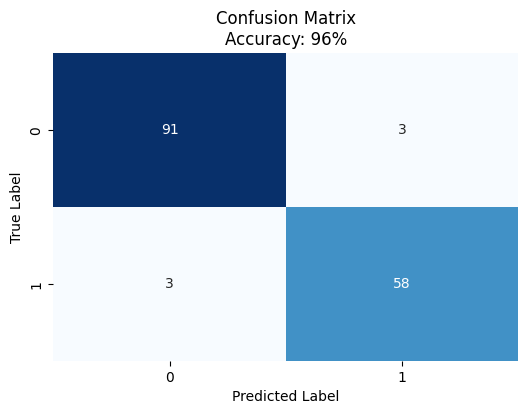

In [24]:
# Plot Confusion Matrix for Bert Model
plot_confusion_matrix(test_labels, y_hat)

### Conclusion: BERT is Best Suited

- While Naive Bayes and LSTM did well, BERT's ability to understand word context makes it the better choice.
- BERT handles complex language and nuanced text far more effectively, reducing errors where the other models struggled.
- I'll move forward with BERT for production, as it offers the most reliable performance for the task.

In [26]:
model.save("/content/model")

In [27]:
!zip -r /content/model.zip /content/model

  adding: content/model/ (stored 0%)
  adding: content/model/fingerprint.pb (stored 0%)
  adding: content/model/keras_metadata.pb (deflated 94%)
  adding: content/model/assets/ (stored 0%)
  adding: content/model/saved_model.pb (deflated 92%)
  adding: content/model/variables/ (stored 0%)
  adding: content/model/variables/variables.data-00000-of-00001 (deflated 28%)
  adding: content/model/variables/variables.index (deflated 78%)


In [28]:
from google.colab import files
files.download("/content/model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [29]:
import shutil
from google.colab import files

# Zip the model directory
shutil.make_archive('/content/model', 'zip', '/content/model')

# Download the zip file
files.download('/content/model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>